In [29]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

from adefc_vortex.math_module import xp, xcipy, ensure_np_array
from adefc_vortex import utils
from adefc_vortex.imshows import imshow1, imshow2, imshow3, plot_data
import adefc_vortex.scoob_interface as scoobi
# import scoobi.utils as utils

import lina

print(scoobi.__file__)
print(lina.__file__)

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()

client = IndiClient()
client.connect()
client.get_properties()

def restart_clients():
    client0 = INDIClient('localhost', 7624)
    client0.start()

    client = IndiClient()
    client.connect()
    client.get_properties()

/home/kianmilani/Projects/adefc-vortex/adefc_vortex/scoob_interface.py
/home/kianmilani/Projects/lina/lina/__init__.py


Exception in thread IndiTcpClientConnection-receiver:
Traceback (most recent call last):
  File "/opt/conda/envs/km310env/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/envs/km310env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/opt/conda/envs/km310env/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/MagAOX/source/purepyindi2/purepyindi2/transports.py", line 117, in _handle_inbound
    self._parser.parse(data)
  File "/opt/MagAOX/source/purepyindi2/purepyindi2/parser.py", line 59, in parse
    self.parser.Parse(data)
  File "/home/conda/feedstock_root/build_artifacts/python-split_1710937908195/work/Modules/pyexpat.c", line 475, in EndElement
  File "/opt/MagAOX/source/purepyindi2/purepyindi2/parser.py", line 174, in end_xml_element_handler
    element.set_from_text(contents)
  File "/opt/MagAOX/source/purepyind

In [30]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', dm_channel='dm00disp02')
I.npsf = 256

In [23]:
reload(scoobi)
scoobi.set_zwo_bin(4, client0)

In [27]:
reload(scoobi)
xc, yc = (4600, 3400)
xc, yc = (4000, 3300)
npsf = 512
scoobi.set_zwo_roi(xc, yc, npsf, client0)


KeyboardInterrupt: 

In [68]:
I.set_zwo_exp_time(0.0002, client0)

Set the ZWO exposure time to 2.00e-04s


In [69]:
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [40]:
I.set_fib_atten(32, client)

Set the fiber attenuation to 32.0


In [17]:
scoobi.move_psf(5, 0, client0)

In [19]:
scoobi.move_psf(0, -5, client0)

# Run FDPR2

In [41]:
from magpyx.utils import ImageStream
fdpr2_amp_stream = ImageStream('fdpr2_amp')
fdpr2_phs_stream = ImageStream('fdpr2_phase')

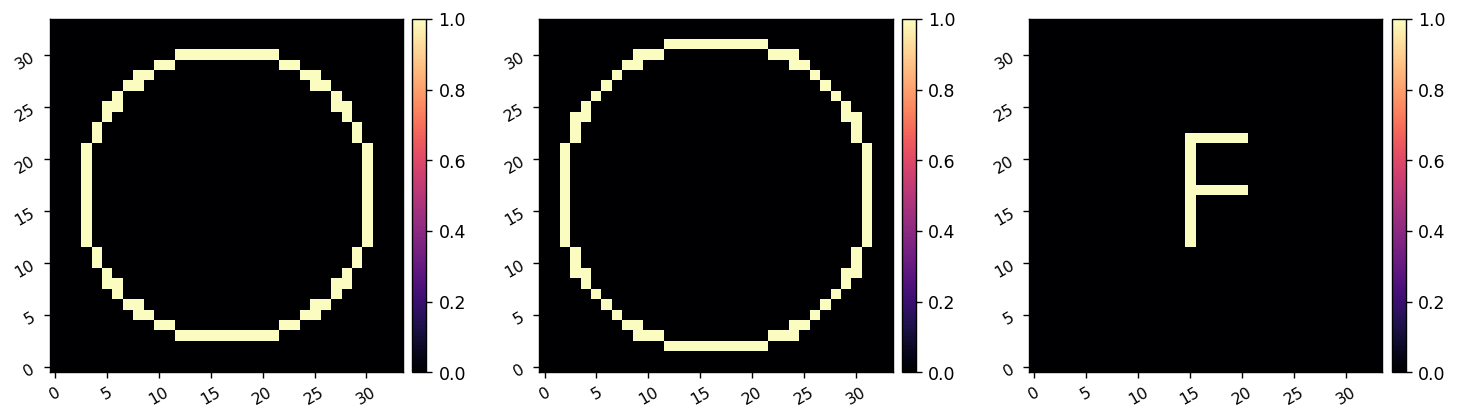

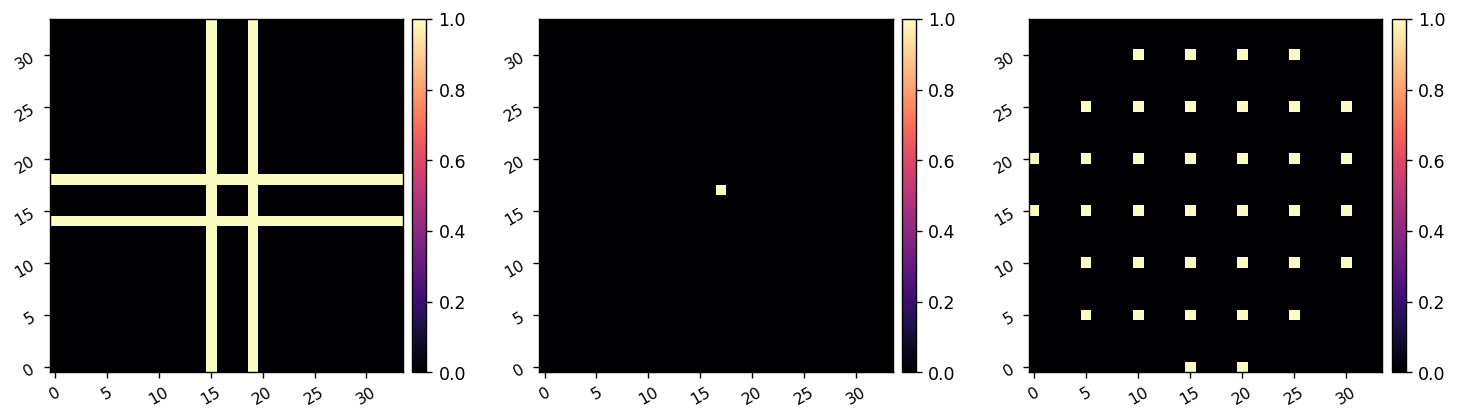

In [42]:
reload(lina.utils)

ring_13 = lina.utils.make_ring(rad=13, Nact=34)
ring_14 = lina.utils.make_ring(rad=14, Nact=34)
ring_15 = lina.utils.make_ring(rad=15, Nact=34)
ring_16 = lina.utils.make_ring(rad=16, Nact=34)
f = lina.utils.make_f()
imshow3(ring_14, ring_15, f)

cross = lina.utils.make_cross_command(xc=[-1, 3], yc=[2,-2])

poke = np.zeros((34,34))
poke[17,17] = 1
# poke[25,17] = 1
# poke[18,31] = 1

pokes = np.zeros((34,34))
for i in range(34):
    for j in range(34):
        if i%5==0 and j%5==0:
            pokes[i,j] = 1
pokes *= I.dm_mask
imshow3(cross, poke, pokes)

In [93]:
amp = 50e-9
# command = np.zeros((34,34))
# command = amp*ring_13
# command = amp*ring_14
# command = amp*ring_15
# command = amp*ring_16
# command = amp*f
# command = amp*cross
command = amp*pokes

I.set_dm(command)

INFO:utils:Got semaphore index 1.
INFO:fdpr2:Estimated phase RMS: 0.0982 (rad)
INFO:fdpr2:Estimated amplitude RMS: 6.01 (%)
INFO:fdpr2:Estimated Strehl: 0.99 (0.99 phase-only and 1.00 amplitude-only)
INFO:fdpr2:Updated shmims fdpr2_phase and fdpr2_amp


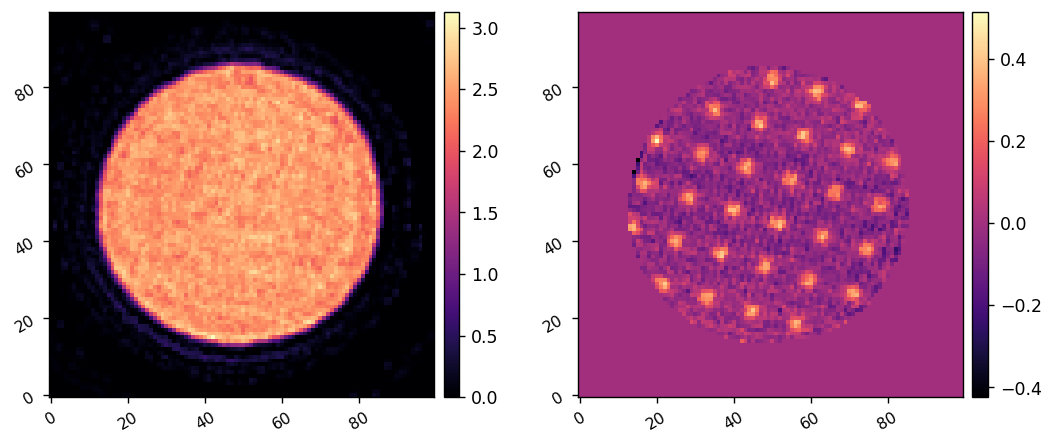

In [94]:
from magpyx.fdpr2 import console, tools

config_params = tools.Configuration('fdpr2_fpm')

fitdict, Imeas_cen = console.estimate_oneshot(config_params)
I.zero_dm()

fitdict.update({
    'AMP':fdpr2_amp_stream.grab_latest(),
    'PHS':fdpr2_phs_stream.grab_latest(),
    'dm_command':command,
    'Imeas':Imeas_cen, 
})

imshow2(fitdict['AMP'], fitdict['PHS'], npix=100)

In [95]:
# utils.save_pickle(f'data/{today}_fdpr2_prefpm_ref.pkl', fitdict)
# utils.save_pickle(f'data/{today}_fdpr2_prefpm_ring_13.pkl', fitdict)
# utils.save_pickle(f'data/{today}_fdpr2_prefpm_ring_14.pkl', fitdict)
# utils.save_pickle(f'data/{today}_fdpr2_prefpm_ring_15.pkl', fitdict)
# utils.save_pickle(f'data/{today}_fdpr2_prefpm_ring_16.pkl', fitdict)
# utils.save_pickle(f'data/{today}_fdpr2_prefpm_f.pkl', fitdict)
# utils.save_pickle(f'data/{today}_fdpr2_prefpm_cross.pkl', fitdict)
utils.save_pickle(f'data/{today}_fdpr2_prefpm_pokes.pkl', fitdict)



Saved data to:  data/20250121_fdpr2_prefpm_pokes.pkl


In [33]:
I.zero_dm()

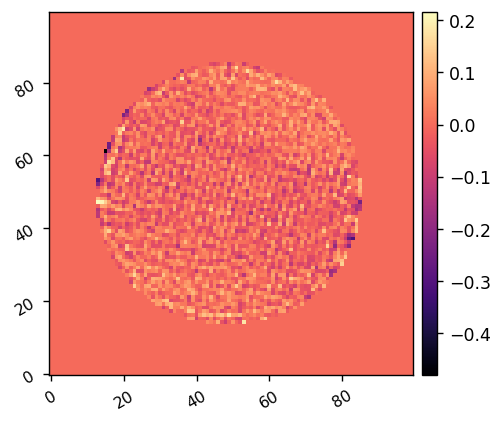

In [97]:
date = 20250121

ref_data = utils.load_pickle(f'data/{date}_fdpr2_prefpm_ref.pkl')
ref_phs = ref_data['PHS']
imshow1(ref_phs, npix=100)

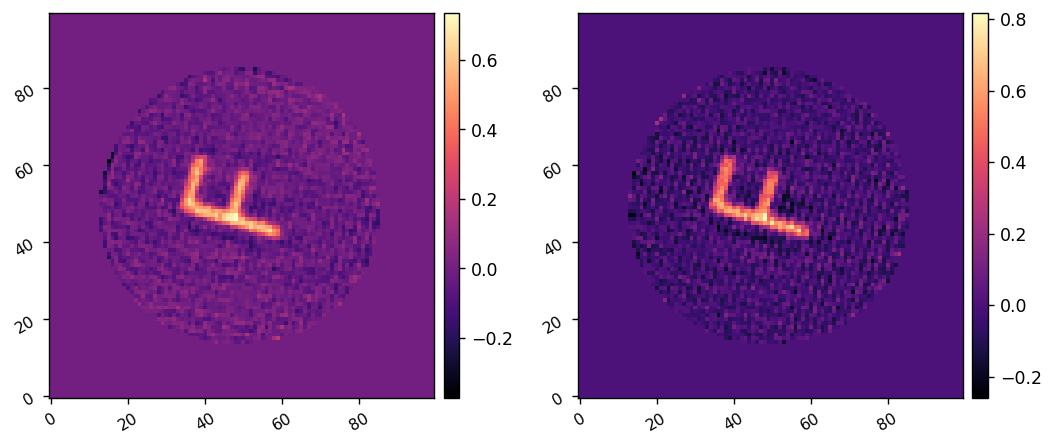

In [98]:
f_data = utils.load_pickle(f'data/{date}_fdpr2_prefpm_f.pkl')
f_phs = f_data['PHS']
diff = f_phs-ref_phs
imshow2(f_phs, diff, npix=100)

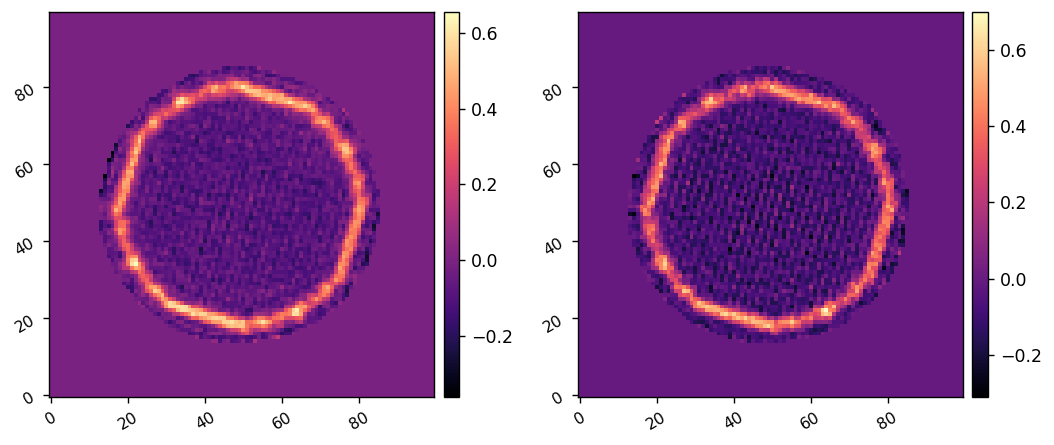

In [99]:
ring13_data = utils.load_pickle(f'data/{date}_fdpr2_prefpm_ring_13.pkl')
ring13_phs = ring13_data['PHS']
diff = ring13_phs-ref_phs
imshow2(ring13_phs, diff, npix=100)

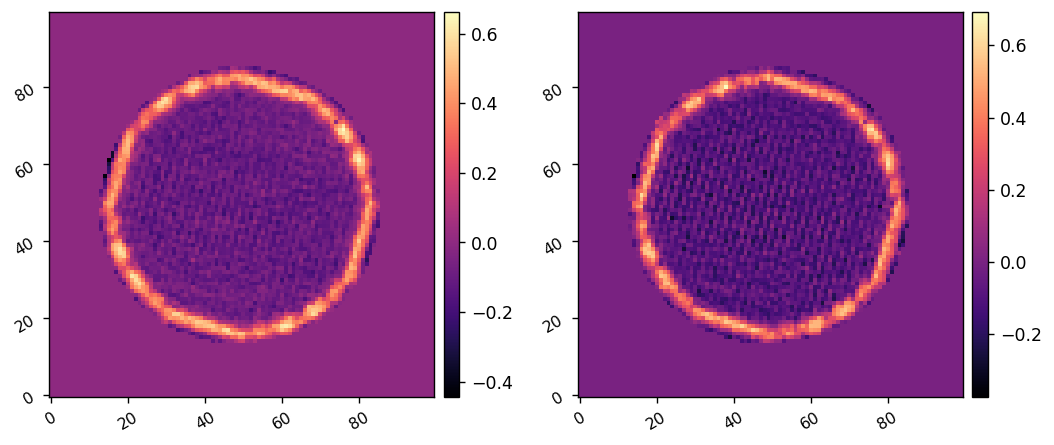

In [100]:
ring14_data = utils.load_pickle(f'data/{date}_fdpr2_prefpm_ring_14.pkl')
ring14_phs = ring14_data['PHS']
diff = ring14_phs-ref_phs
imshow2(ring14_phs, diff, npix=100)

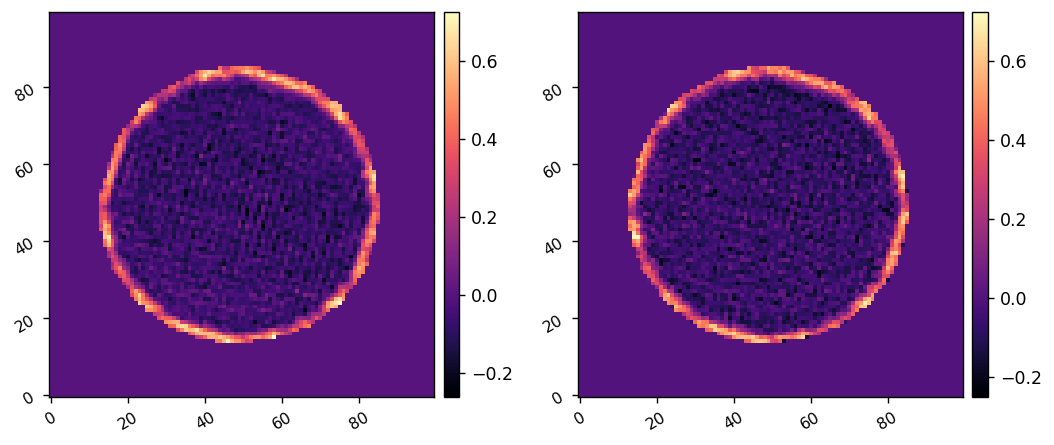

In [104]:
ring15_data = utils.load_pickle(f'data/{date}_fdpr2_prefpm_ring_15.pkl')
ring15_phs = ring15_data['PHS']
diff = ring15_phs-ref_phs
imshow2(ring15_phs, diff, npix=100)

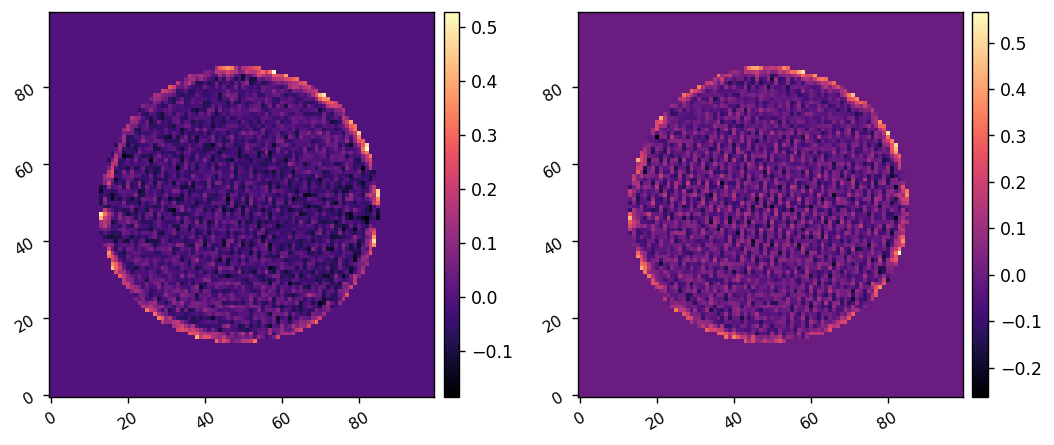

In [103]:
ring16_data = utils.load_pickle(f'data/{date}_fdpr2_prefpm_ring_16.pkl')
ring16_phs = ring16_data['PHS']
diff = ring16_phs-ref_phs
imshow2(ring16_phs, diff, npix=100)

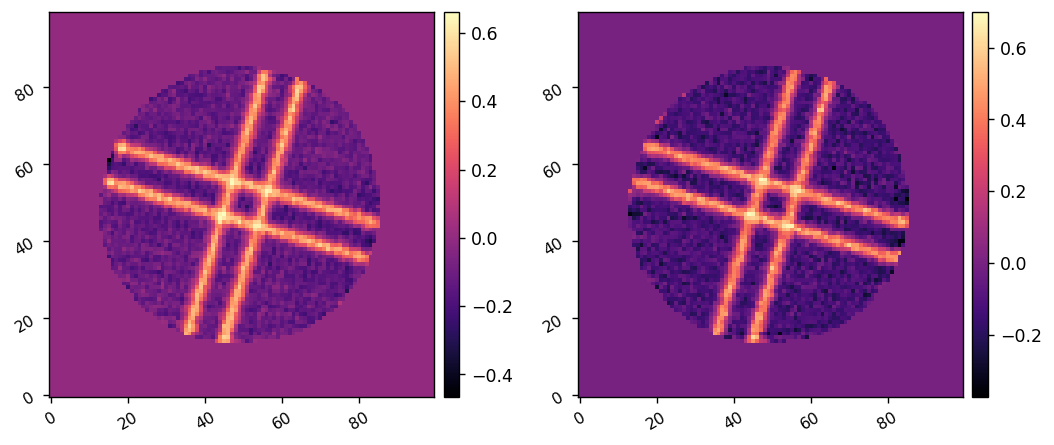

In [105]:
cross_data = utils.load_pickle(f'data/{date}_fdpr2_prefpm_cross.pkl')
cross_phs = cross_data['PHS']
diff = cross_phs-ref_phs
imshow2(cross_phs, diff, npix=100)

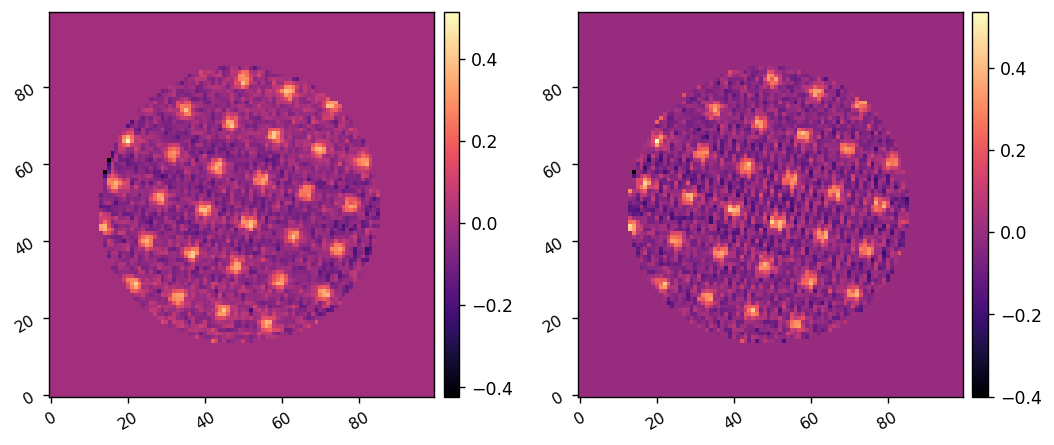

In [106]:
pokes_data = utils.load_pickle(f'data/{date}_fdpr2_prefpm_pokes.pkl')
pokes_phs = pokes_data['PHS']
diff = pokes_phs-ref_phs
imshow2(pokes_phs, diff, npix=100)